# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [11]:
#!pip3 install vpython 

In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
from sklearn.metrics import accuracy_score
#import visuals as vs

%matplotlib inline

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download(['punkt', 'wordnet', 'stopwords',
               'averaged_perceptron_tagger'])


df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()[:5]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()[:5]

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [17]:
df.shape

(45993, 3)

In [3]:
articles_by_user=df.groupby('email')['article_id'].count()

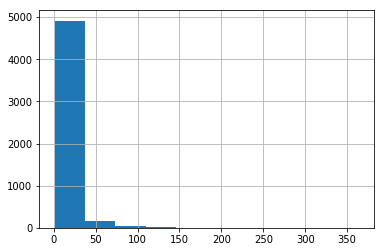

In [6]:
articles_by_user.hist()

In [18]:
# Which user interacts with articles the most? How many users interact with articles? 
#Which email is the most frequent?
df['email'].describe()

count                                        45976
unique                                        5148
top       2b6c0f514c2f2b04ad3c4583407dccd0810469ee
freq                                           364
Name: email, dtype: object

In [19]:
# Which columns have null values
df.isnull().sum()[df.isnull().sum()>0]

email    17
dtype: int64

In [21]:
user_interactions=df['email'].value_counts()

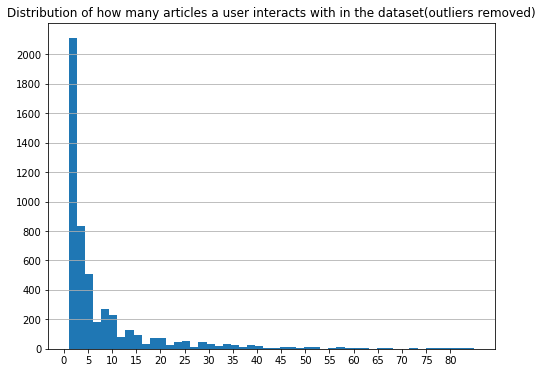

In [28]:
articles_by_user = df.groupby('email').count()['title']
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(articles_by_user, bins=50, range=(1,85))
ax.set_xticks(np.arange(0,85,5))
ax.set_yticks(np.arange(0,2200, 200))
ax.set_title('Distribution of how many articles a user interacts with in the dataset(outliers removed)')
ax.grid(which='major', axis='y')
plt.show();

In [29]:
user_interactions.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: email, dtype: float64

In [70]:
# 50% of individuals interact with _3_  of articles or fewer.
median_val = 3
# The maximum number of user-article interactions by any 1 user is _364_.
max_views_by_user =364 

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [40]:
# Find and explore duplicate articles
#duplicate articles
for col in df_content.columns:
    print('{} duplicates: {}'.format(col, df_content.duplicated(col).sum()))

doc_body duplicates: 19
doc_description duplicates: 31
doc_full_name duplicates: 0
doc_status duplicates: 1050
article_id duplicates: 0


In [41]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset='article_id', keep='first', inplace=True)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [49]:
#number of unique articles with a user interaction-in the user interaction dataset
df.article_id.unique().shape

(714,)

In [53]:
# The number of unique articles on the IBM platform
df_content.article_id.nunique()

1051

In [54]:
# The number of unique users
df.email.nunique()

5148

In [58]:
# The number of user-article interactions
df.shape[0]

45993

In [71]:
# The number of unique articles that have at least one interaction
unique_articles = 714
# The number of unique articles on the IBM platform
total_articles = 1051
 # The number of unique users
unique_users =5148
# The number of user-article interactions
user_article_interactions = 45993

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [61]:
# The most viewed article in the dataset as a string with one value following the decimal 
df.title.describe()

count                                          45993
unique                                           714
top       use deep learning for image classification
freq                                             937
Name: title, dtype: object

In [65]:
df.article_id.value_counts().head()

1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
Name: article_id, dtype: int64

In [74]:
#Use deep learning for image classification
most_viewed_article_id = '1429.0' 
# The most viewed article in the dataset was viewed how many times?
max_views =937 

In [66]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [75]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [76]:
#check the column names
df.columns

Index(['article_id', 'title', 'user_id'], dtype='object')

In [90]:
#est out a method that we would use as a function, to retrieve the top articles
list(df.title.value_counts().head(10).index)

['use deep learning for image classification',
 'insights from new york car accident reports',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'predicting churn with the spss random tree algorithm',
 'healthcare python streaming application demo',
 'finding optimal locations of new store using decision optimization',
 'apache spark lab, part 1: basic concepts',
 'analyze energy consumption in buildings',
 'gosales transactions for logistic regression model']

In [91]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles=list(df.title.value_counts().head(n).index)
    
    return top_articles # Return the top article titles from df 

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles=list(df.article_id.value_counts().head(n).index)
 
    return top_articles # Return the top article ids

In [92]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [93]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [94]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    user_item = df.groupby(["user_id", "article_id"])["title"].max().unstack()
    user_item = user_item.notnull().astype(int)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [95]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [96]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    similarity = user_item.dot(user_item.loc[user_id])
    # sort by similarity
    similarity = similarity.sort_values(ascending=False)
    # create list of just the ids
    similarity.drop(user_id, inplace=True)
    # remove the own user's id
    most_similar_users = list(similarity.index)  
    return most_similar_users # return a list of the users in order from most to least similar
        

In [97]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


In [101]:
article_ids =[111.0, 1427.0]

In [103]:
 df[df["article_id"].isin(article_ids)]["title"].unique()

array(['use xgboost, scikit-learn & ibm watson machine learning apis',
       'tidy up your jupyter notebooks with scripts'], dtype=object)

`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [104]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    
    article_names = df[df["article_id"].isin(article_ids)]["title"].unique().tolist()
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    row_user = user_item.loc[user_id]
    article_ids = list(row_user[row_user > 0].index)
    article_ids = [str(x) for x in article_ids]
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    similar_users = find_similar_users(user_id)
    recs = []
    seen_ids, _ = get_user_articles(user_id)
    
    #iterate thru users
    for user in similar_users:
        ids, names = get_user_articles(user)
        
        #find ids that have not been read by user yet
        not_seen = list(set(ids) - (set(seen_ids) & set(ids)))
        
        #add to recs
        recs.extend(not_seen)
        if(len(recs)>=m): break #when we have found enough articles
    
    return recs # return your recommendations for this user_id    

In [105]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['healthcare python streaming application demo',
 'ml optimization using cognitive assistant',
 'deploy your python model as a restful api',
 'visualize data with the matplotlib library',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'the unit commitment problem',
 'timeseries data analysis of iot events by using jupyter notebook',
 'the nurse assignment problem',
 'dsx: hybrid mode',
 'predicting churn with the spss random tree algorithm',
 'data science for real-time streaming analytics',
 'analyze energy consumption in buildings',
 'analyze open data sets with pandas dataframes',
 'intents & examples for ibm watson conversation',
 'apache spark lab, part 3: machine learning',
 'gosales transactions for logistic regression model',
 'leverage python, scikit, and text classification for behavioral profiling',
 'insights from new york car accident reports',
 'maximize oil company profits',
 'using github for project control in dsx',
 'use sql with data in

In [106]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [107]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    #find user similarity w/ dot product
    similarity = user_item.dot(user_item.loc[user_id])
    
    # sort by similarity
    similarity = similarity.sort_values(ascending=False).drop(user_id).to_frame(name='similarity').reset_index()

    #get number of interactions for each user
    num_interactions = df.user_id.value_counts().to_frame('num_interactions')
    
    #combine the value counts with similarity
    neighbors_df = similarity.merge(num_interactions, left_on='user_id', 
                        right_index=True).rename(columns={'user_id':'neighbor_id'})

    neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False, inplace=True)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    try:
        #get already read articles
        user_article_ids, _ = get_user_articles(user_id)
    except KeyError: #user does not exist
        recs = get_top_article_ids(m)
        return recs, get_article_names(recs)
    #get neighbors sorted by similarity (descending)
    neighbours = get_top_sorted_users(user_id).neighbor_id.values
    
    #get top 400 articles (their ids), if outside of top 400 we dont want to recommend
    all_articles_sorted = get_top_article_ids(300)
    
    recs = []
    
    for user in neighbours:
        neighbour_article_ids, _ = get_user_articles(user)
        not_seen = list(set(neighbour_article_ids)-(set(user_article_ids)&set(neighbour_article_ids)))
        
        #sort by highest ranked articles, add to list
        not_seen_sorted = list(set(all_articles_sorted) &set(not_seen))
        
        recs.extend(not_seen)
        if(len(recs)>=m):
            recs = recs[:m]
            break; #do not add any more
    
    return recs, get_article_names(recs)

In [108]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1331.0', '1356.0', '651.0', '1162.0', '302.0', '1278.0', '1433.0', '1386.0', '1407.0', '555.0']

The top 10 recommendations for user 20 are the following article names:
['analyze energy consumption in buildings', 'accelerate your workflow with dsx', 'intentional homicide, number and rate per 100,000 population, by country', 'occupation (2015): united states demographic measures', 'analyzing streaming data from kafka topics', 'uci: poker hand - testing data set', 'visualize the 1854 london cholera outbreak', 'develop a scala spark model on chicago building violations', 'small steps to tensorflow', 'build a naive-bayes model with wml & dsx']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [110]:
get_top_sorted_users(1).head()

,neighbor_id,similarity,num_interactions
0,3933,35,45
1,23,17,364
2,3782,17,363
3,203,15,160
4,4459,15,158


In [111]:
get_top_sorted_users(131).head(10)

,neighbor_id,similarity,num_interactions
0,3870,74,144
1,3782,39,363
2,23,38,364
4,203,33,160
3,4459,33,158
5,98,29,170
6,3764,29,169
8,49,29,147
7,3697,29,145
9,242,25,148


In [112]:
### Tests with a dictionary of results

user1_most_sim =3933 # Find the user that is most similar to user 1 
user131_10th_sim = 242# Find the 10th most similar user to user 131

In [113]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Response :**
If we were given a new user, we would have no information about the user, the user preferences thus we cannot use similarities to recommend articles. We would have to use rank based recommendations and recommend the most popular articles and articles with the most interactions. Since the user is new they most likely will be interested or will want to review the most popular articles first. This is a problem because, the most popular articles will become more popular due to this and will get more views making them to be recommended to new users first. Also by recommending the most popular items to the user, it will disturb or bias our algorithm since it will recommend these to our users because the user viewed them not neccesarily because the user prefers them. As the user base grows, popularity of articles will change and rank based approach is biased against that.

**Possible Solution:**
A new user can provide some filters that provide the algorithm with knowledge about the user and this can be used to find similarities between the user preferences and the other users

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [137]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 

# List of the top 10 article ids you would give to
new_user_recs = [str(x) for x in get_top_article_ids(10)]

In [138]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations </a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term. 

`1.` We will consider using the titles to make content based  recs. By looking at the most common words in each title and most common words in popular titles. If user is new, we will recommend popular titles

`2.` We will also consider using the text. If user is new but is willing to give us few words representing his topics of interest we could then use those words to find most related articles.
When user has few interactions, we could use a mix of collaborative filtering and content-based recommendation as for example with only one article read, it is not so obvious to find the "same" user and result might be disappointing. 



### Using Titles

In [139]:
nltk.download('abc')
#nltk.download('webtext')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

[nltk_data] Downloading package abc to /root/nltk_data...
[nltk_data]   Unzipping corpora/abc.zip.


In [140]:
def tokenize(x):
    '''
    Tokenize any string into seperate words. 
    Use lemmatizer to break words down into core forms, and then keep only words with meaning

    Inputs
    x (str) - string to break down

    Outputs
    filtered (array, str) - words that are special to the string
    '''
    stop_words = (set(stopwords.words('english')) | set(nltk.corpus.abc.words()))
    tokens = word_tokenize(x) #split each message into individual words
    lemmatizer = WordNetLemmatizer()
    clean_tokens=[]
    for token in tokens:
        #clean each token from whitespace and punctuation, and conver to
        #root of word ie walking->walk
        clean_token = lemmatizer.lemmatize(token).lower().strip()
        clean_tokens.append(clean_token)
        
    filtered = [word for word in clean_tokens if word not in stop_words and word.isalpha()]
    return filtered



In [141]:
def make_content_recs(data_id, user_id=True, m=10, df=df):
    '''
    INPUT:
        data_id (str) - id of either user or article
        user_id (bool) - if true, make recs based on user
        m (int) - number of recommendations to give based on term
    OUTPUT:
        recs (list) - list of article ids that are recommended
        rec_names (list) - list of article names that are recommended
        
    Description:
       This content based recommender looks at the articles the user has interacted with.
       It goes through each article title and using he NLTK library, finds the most common words
       (related to content) throughout all the articles.
              
       Based on these most common words, the recommender looks at the sums of words in
       the title of each article, and based on the number of matches as well as the
       general popularity of the article it gives back the best recommendations.
    '''
    if(user_id):
        user_id = data_id
        try:
            #get already read articles
            article_ids, _ = get_user_articles(user_id)
        except KeyError: #user does not exist
            print('User Doesnt Exist, Recommending Top Articles')
            recs = get_top_article_ids(m)
            return recs, get_article_names(recs)
    
    else:
        article_ids = data_id
        
    title_data = df.drop_duplicates(subset='article_id') #drop duplicates 
    titles = title_data[title_data.article_id.isin(list(map(float, article_ids)))].title
    
    #tokenize the words in each article title
    title_words=[]
    tokenized = tokenize(titles.str.cat(sep=' '))
    title_words.extend(tokenized)
    
    #find the highest occuring words
    common_words = pd.value_counts(title_words).sort_values(ascending=False)[:10].index

    top_matches={}
    #count number of occurences of each common word in other article titles (this measures similarity)
    for word in common_words:
        word_count = pd.Series(title_data.title.str.count(word).fillna(0)) #gets occurences of each word in title
        top_matches[word] = word_count
                    
    top_matches = pd.DataFrame(top_matches) # num_cols== num of most common words
    top_matches['top_matches'] = top_matches.sum(axis=1)
    top_matches['article_id'] = title_data.article_id.astype(float)
    
    #get most interacted with articles
    article_occurences = pd.DataFrame({'occurences':df.article_id.value_counts()})

    #sort matches by most popular articles
    top_matches = top_matches.merge(article_occurences, left_on='article_id', right_index=True)
    top_matches.sort_values(['top_matches', 'occurences'], ascending=False, inplace=True)    
    
    #drop already read articles
    recs_df = top_matches[~top_matches.article_id.isin(list(map(float, article_ids)))]
    
    #get rec id and names
    recs = recs_df.article_id[:m].values.astype(str)
    rec_names = get_article_names(recs)
    
    return recs, rec_names


**Content Based Recommender - Explanation**

This content based recommender looks at the articles the user has interacted with. It goes through each article and using he NLTK library, finds the most common words in the titles of each article.

Based on these most common words, the recommender looks at the sums of words relevant words in the title of each article, and based on the number of matches in the titles as well as the general popularity of the article it gives back the best recommendations.

If the user has not read any articles yet, then we can't really give any content based recommendations, and just return back some of the most popular articles.




#### Illustrated

In [142]:
# make recommendations for a brand new user
make_content_recs('0.0', user_id=True)

User Doesnt Exist, Recommending Top Articles


([1429.0,
  1330.0,
  1431.0,
  1427.0,
  1364.0,
  1314.0,
  1293.0,
  1170.0,
  1162.0,
  1304.0],
 ['healthcare python streaming application demo',
  'use deep learning for image classification',
  'apache spark lab, part 1: basic concepts',
  'predicting churn with the spss random tree algorithm',
  'analyze energy consumption in buildings',
  'visualize car data with brunel',
  'use xgboost, scikit-learn & ibm watson machine learning apis',
  'gosales transactions for logistic regression model',
  'insights from new york car accident reports',
  'finding optimal locations of new store using decision optimization'])

In [145]:
# make a recommendations for a user who only has interacted with article id '1427.0'
make_content_recs(['1427.0'], user_id=False)

(array(['1159.0', '390.0', '1332.0', '1324.0', '241.0', '1422.0', '969.0',
        '729.0', '14.0', '254.0'], 
       dtype='<U32'),
 ['got zip code data? prep it for analytics. – ibm watson data lab – medium',
  'ibm watson facebook posts for 2015',
  'intents & examples for ibm watson conversation',
  'use r dataframes & ibm watson natural language understanding',
  'pixiedust 1.0 is here! – ibm watson data lab',
  'i am not a data scientist – ibm watson data lab',
  'flightpredict ii: the sequel  – ibm watson data lab',
  'introducing ibm watson studio ',
  'apple, ibm add machine learning to partnership with watson-core ml coupling',
  'analyze facebook data using ibm watson and watson studio'])

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [152]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [153]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  

In [154]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)# use the built in to get the three matrices

In [157]:
u.shape

(5149, 5149)

In [158]:
s.shape

(714,)

In [159]:
vt.shape

(714, 714)

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

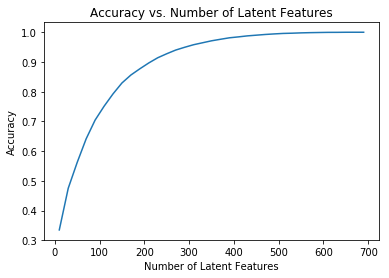

In [160]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [162]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)

    test_idx = user_item_test.index
    test_arts = user_item_test.columns
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [163]:
# 'How many users can we make predictions for in the test set?'
np.intersect1d(user_item_test.index, user_item_train.index).size

20

In [164]:
# 'How many users in the test set are we not able to make predictions for because of the cold start problem?'
len(set(user_item_test.index) - set(user_item_train.index))

662

In [165]:
# 'How many articles can we make predictions for in the test set?'
np.intersect1d(user_item_test.columns, user_item_train.columns).size

574

In [166]:
# 'How many articles in the test set are we not able to make predictions for because of the cold start problem?'
len(set(user_item_test.columns) - set(user_item_train.columns))

0

In [167]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?':a , 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?':d ,
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [168]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)# fit svd similar to above then use the cells below

In [ ]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

In [169]:
# Subset of rows in the user_item_test dataset that you can predict

#  Rows that match the test set
test_idx = user_item_test.index
row_idxs = user_item_train.index.isin(test_idx)
u_test = u_train[row_idxs, :]

#  Columns that match the test set
test_col = user_item_test.columns
col_idxs = user_item_train.columns.isin(test_col)
vt_test = vt_train[:, col_idxs]

In [170]:
# Test data
train_idx = user_item_train.index
row_idxs_2 = user_item_test.index.isin(train_idx)
sub_user_item_test = user_item_test.loc[row_idxs_2]

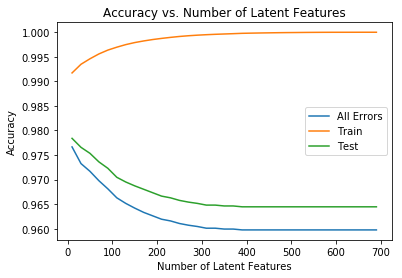

In [173]:
latent_feats = np.arange(10, 700+10, 20)

all_errs, train_errs, test_errs = [], [], []


for k in latent_feats:
    # restructure with k latent features
    s_train_lat, u_train_lat, vt_train_lat = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    u_test_lat, vt_test_lat = u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_train_preds = np.around(np.dot(np.dot(u_train_lat, s_train_lat), vt_train_lat))
    user_item_test_preds = np.around(np.dot(np.dot(u_test_lat, s_train_lat), vt_test_lat))
    
    all_errs.append(1 - ((np.sum(user_item_test_preds)+np.sum(np.sum(sub_user_item_test)))/(sub_user_item_test.shape[0]*sub_user_item_test.shape[1])))

    # compute prediction accuracy
    train_errs.append(accuracy_score(user_item_train.values.flatten(), user_item_train_preds.flatten()))
    test_errs.append(accuracy_score(sub_user_item_test.values.flatten(), user_item_test_preds.flatten()))


plt.figure()
plt.plot(latent_feats, all_errs, label='All Errors')
plt.plot(latent_feats, train_errs, label='Train')
plt.plot(latent_feats, test_errs, label='Test')
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')
plt.legend()
plt.show()

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Analysis of Results.**

There are only 20 users which are common between the testing and training set, this means that we have very litle data to base and rate the perfomance of our model. Our data distribution  is highly imbalanced.

The results from the training are inverse from the ones in the test set. During training it appeared that the more latent features the more the accuracy increased perhaps this was due to overfitting. During testing we see that the accuracy starts drastically decreasing as we increase the latent features. 

We could only make predictions on 574 articles read by 20 people which isnt much.

An A/B test could be conducted to see the effectiveness of the matrix recommendation system in comparison to a different recommendation system (for example the rank based recommendation which would be a very basic baseline comparison).

The null-hypothesis in this case would be that there is no difference between the matrix recommendation system and the rank based recommendation system in terms of the number of clicks on the recommended articles. This could also be potentially expanded to the time spent on the articles when clicked as well. This would give a more accurate idea of how much that user likes that article.

The A/B test would show one group only the rank based recommendations while the B group would see only the matrix recommendations. We could split the users by cookie based diversion, so that an equal number of cookies are split between A and B groups. This would be the invariant metric.

Since we are currently working on offline mode, we do not have a time constraint. But for practical significance, we should keep running this experiment for at least one month to start seeing the results on the platform.

As we increase the incubation time of our experiment, we also need to gather more data. Just 20 user ids do not reflect the diversity of the user base.

Extending to content-based recommendation for the cold-start problem can be a good idea.